In [122]:
DATA_LOCATION = 'data2node.txt'
OUTPUT_FILE = 'result.tmp'

VERBOSE = False
TO_FILE = True
MULT_FACTOR = 50
TRAIN_SET_PERCENTAGE = [15,35,55,75,95]

In [123]:
import numpy as np
np.set_printoptions(precision=3, suppress=True)
import os
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow import keras

In [124]:
#Debugging
def log(s):
    if VERBOSE:
        print(s)
    if TO_FILE:
        if os.path.exists(OUTPUT_FILE):
            append_write = 'a'
        else:
            append_write = 'w'
        fh = open(OUTPUT_FILE, append_write)
        fh.write(s + '\n')
        fh.close()

            
# Loading data from the files
def preprocess():
    data = []
    results = []

    with open(DATA_LOCATION) as data_file:
        for row in data_file:
            num_list = list(map(int, row.split(' ')))
            for i in range(MULT_FACTOR):
                data.append(num_list[:-1])
                results.append(num_list[-1:])
    return pd.DataFrame(data), pd.DataFrame(results)

# Tiny model
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(100, input_dim=4,  activation='relu'),
        layers.Dense(50, activation='relu'),
        layers.Dense(1, activation='linear')
    ])

    model.compile(loss='mean_squared_error',
                  optimizer='adam')
    return model

def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

def plot_prediction(actual_values, preds):
    a = plt.axes(aspect='equal')
    plt.scatter(actual_values.T, preds)
    plt.xlabel('True Values [MPG]')
    plt.ylabel('Predictions [MPG]')
    lims = [0, 50]
    plt.xlim(lims)
    plt.ylim(lims)
    _ = plt.plot(lims, lims)
    
def plot_error(error):
    plt.hist(error.T, bins=25)
    plt.xlabel('Percentage error')
    plt.ylabel('Count')
    
def plot_all_predictions(preds, act_vals):
    fig, axs = plt.subplots(len(TRAIN_SET_PERCENTAGE), sharex=True, sharey=True)
    
    lims = [0, 50]
    
    fig.suptitle('Predictions / Actual Values')
    fig.supxlabel('True Values')
    fig.supylabel('Predictions')

    for i in range(len(TRAIN_SET_PERCENTAGE)):
        axs[i].scatter(act_vals.T, preds[i])
        axs[i].set_xlim(lims)
        axs[i].set_ylim(lims)
        axs[i].plot(lims,lims)
        axs[i].set_title(str(TRAIN_SET_PERCENTAGE[i]) + "% of data")
        
    
def plot_all_errors(errors):
    fig, axs = plt.subplots(len(TRAIN_SET_PERCENTAGE), sharex=True, sharey=True)
    
    fig.suptitle('Percentage errors')
    fig.supxlabel('True Values')
    fig.supylabel('Predictions')

    for i in range(len(TRAIN_SET_PERCENTAGE)):
        axs[i].hist(errors[i].T, bins=25)
        axs[i].set_xlabel('Percentage error')
        axs[i].set_ylabel('Count')
        axs[i].set_title(str(TRAIN_SET_PERCENTAGE[i]) + "% of data")

In [125]:
def train_iter(data_train, full_test, result_train, full_res):

    eval_results = []
    abs_percentage_errors = []
    train_sizes = []
    predictions = []
    full_errors = []
    
    # Take data in 20% increments
    for i in TRAIN_SET_PERCENTAGE:
        print("Starting iteration")

        # Get the current segment
        test_sz = i/100
        _, data_slice, _, result_slice = train_test_split(data_train, result_train, test_size=test_sz)
        
        print("Training set is " + str(test_sz) + " of the total data i.e. " + str(len(data_slice)) + " points.")
        train_sizes.append((test_sz, len(data_slice)))

        # Build model
        normalizer.adapt(data_slice)
        dnn_model = build_and_compile_model(normalizer)

        # Train
        print("Starting training")
        history = dnn_model.fit(
            data_slice,
            result_slice,
            validation_split=0.2,
            verbose=VERBOSE,
            epochs=20)
        print("Training done!")

        # Eval
        print("Starging Evaluation")
        eval_res = dnn_model.evaluate(full_test, full_res, verbose=1)
        print("Eval results for test size " + str(test_sz) + " = " + str(eval_res))
        eval_results.append(float(eval_res))

        # Get error
        test_predictions = dnn_model.predict(full_test).flatten()
        predictions.append(test_predictions)
        
        error = (100 * (test_predictions - full_res.T)) / full_res.T
        full_errors.append(error)
        
        abs_error = abs(error).T.sum() / len(full_test)
        print("Error for test size " + str(test_sz) + " = " + str(float(abs_error)))

        abs_percentage_errors.append(float(abs_error))
        print("\n\n")
        
    return abs_percentage_errors, full_errors, predictions, eval_results, train_sizes


In [126]:
# Load the data
print("Loading Data...")
data, res = preprocess()
normalizer = tf.keras.layers.Normalization(axis=-1)
print("Data loaded")

Loading Data...
Data loaded


In [127]:
d,r = preprocess()

data_train, full_test, result_train, full_res = train_test_split(d, r, test_size=0.15)

all_percentage_errors, all_full_errors, all_predictions, all_evals, all_train_sizes = \
train_iter(data_train, full_test, result_train, full_res )

Starting iteration
Training set is 0.15 of the total data i.e. 2550 points.
Starting training
Training done!
Starging Evaluation
94/94 [==============================] - 0s 2ms/step - loss: 7.4524
Eval results for test size 0.15 = 7.452402114868164
94/94 [==============================] - 0s 2ms/step
Error for test size 0.15 = 10.011614324681664



Starting iteration
Training set is 0.35 of the total data i.e. 5950 points.
Starting training
Training done!
Starging Evaluation
94/94 [==============================] - 0s 1ms/step - loss: 6.7853
Eval results for test size 0.35 = 6.7853217124938965
94/94 [==============================] - 0s 1ms/step
Error for test size 0.35 = 10.216751380956984



Starting iteration
Training set is 0.55 of the total data i.e. 9350 points.
Starting training
Training done!
Starging Evaluation
94/94 [==============================] - 0s 1ms/step - loss: 6.7682
Eval results for test size 0.55 = 6.768180847167969
94/94 [==============================] - 0s 1ms/

In [118]:
print("Absolute percentage errors:")
print(all_errors)
print("")
print("Evaluations:")
print(all_evals)

Absolute percentage errors:
[11.082580270734853, 10.531683008930527, 9.529369649770869, 8.074993771349165, 6.0924917147491655]

Evaluations:
[6.947405815124512, 6.66049337387085, 6.288219451904297, 5.263667106628418, 5.385059356689453]


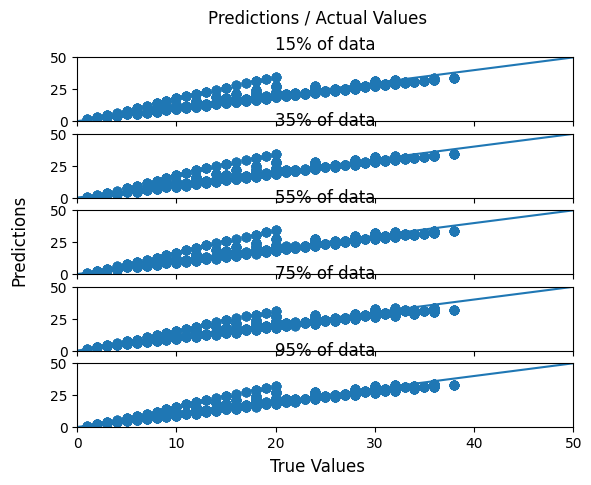

In [119]:
plot_all_predictions(all_predictions, full_res)

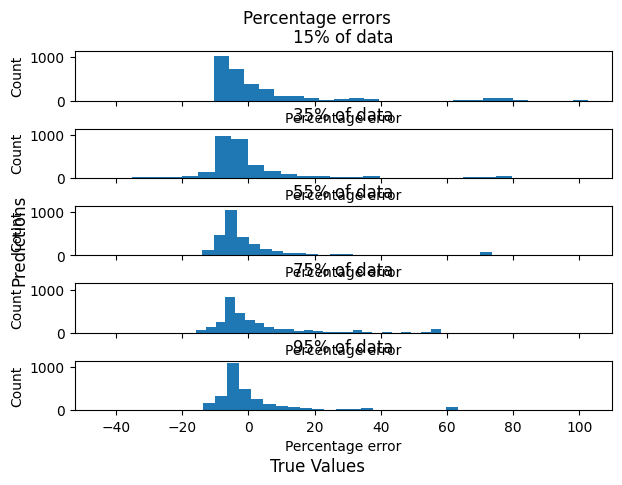

In [120]:
plot_all_errors(all_full_errors)